In [1]:
%matplotlib inline

In [2]:
# Imports, nothing exciting here!
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torch.nn
import torch.nn.functional as F
import sys

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from sith import SITH

# You might need to install seaborn if you haven't already
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

cuda


# 
1) Single training function used by all models
2) Single testing function used by all models
3) Buffer model using embeddings
4) Making it so we don't have to call reset on SITH and Buffer
5) Ensuring all the embeddings are identical for all models
6) Maybe run the three models and combine the plots to really show the differences
7) The minor matplotlib change
8) Try and replace any hard-coded numbers with variables (most are all good, but I think I saw a couple, like the LSTM model instantiation had hard-coded values.)
9) Make it easier to use the tau_star property from the SITH module and get rid of the underscore before it. (edited) 


**GOAL: Learn to predict what letter is coming next given the context of the entire set of letters that came before it.**

In this notebook, we will be covering two models, one with a buffer representation of *history* and one with a SITH representation of history, while they attempt to learn to predict the next item in a predefined sequence. The sequence in this case is the speech about the Sith Lord Darth Plagueis the Wise from Star Wars Episode 3. Individual letters will be presented to the model, one at a time as tokenized one-hot vectors, and the model will have to generate a prediction of what letter should occur next via a log probability. The letter assigned the highest probability is the one that the model has chosen to occur next.  

This notebook is broken up into a few sections. The first is a data pre-processing section where we clean the entire speach and break tokenize it for input to the model. Then we will define a pytorch model with a buffer as the representation of context. Then we will train and test the buffer model, showing graphs of the loss over some number of epochs, as well as the accuracty of predicting the next letter in the speech over some number of epochs. These cells will also show what letter the model is predicting as each letter is being presented to it, once it is fully trained. 

After going over the buffer model, we will replace the buffer with a SITH representation and do the whole process again. The code that trains and tests the model will not change, the only change will be the replacement of the internal buffer of the model with a SITH representation.

# Initialize "Corpus"

Set up the corpus, tokenize the input, and create a list of the target letters

In [3]:
# Define what goes at the end of a sentence, and what comes in the middle of 
# sentences
sentence_enders = ["?", ".", "!"]
separators = ["\'", ","]

# These are all of the tokens included in the stimuli that our model will be 
# seeing
letters = list("abcdefghijklmnopqrstuvwxyz".upper()) + ["<,>", ".", " "]

# create letter ids for the tokenizer function later
let_to_id = {s:x for x,s in enumerate(letters)}
# create a lookup table for model verification later
id_to_let = dict([[v,k] for k,v in let_to_id.items()])

# Read in the entire text
full_text = open("plagueis.txt", "r").read()

# Make them all captical letters, and remove ellipsis. Add space before each 
# sentence ender and sentence separator
full_text = full_text.upper()
full_text = full_text.replace("...", ".")
full_text = full_text.replace(".", " .")
full_text = full_text.replace("?", " ?")
full_text = full_text.replace(",", " ,")
full_test = full_text.replace("\'", " \'")

# split into individual words
split_text = full_text.split()

master_list = []
id_list = []

# Generate list of letter id's to be turned into 1-hot vectors by a 
# tokenizing function. The letter A has the id 0. The letter Z is 25. etc. 
for s in split_text:
    # loop over each letter in each word
    for l in s:
        if l in sentence_enders:
            master_list.append(".")
            id_list.append(let_to_id["."])
        elif l in separators:
            master_list.append("<,>")
            id_list.append(let_to_id["<,>"])
        else:
            master_list.append(l)
            id_list.append(let_to_id[l])
    # add a space after each word and after each sentence modifier
    master_list.append(" ")
    id_list.append(let_to_id[" "])

# tokenizing funciton, turns each letter into 
def tokenize(inp_list, num_tokens=10):
    output = torch.zeros(len(inp_list), num_tokens, 1).type(torch.DoubleTensor)
    for i, inp in enumerate(inp_list):
        output[i, inp, 0] = 1.0
    return output


tokens = torch.DoubleTensor(id_list).view(-1, 1)

# Training and testing functions Function
The goal of the each of the models presented in this notebook are to predict the next letter in the "Darth Plagius" speech from Star Wars Episode 2 given the sequence of letters that came before it. The three models will have a very similar structure:

    Input -> Embedding -> Temporal Representation -> Hidden -> Output

We constructed a single function that could train any of the 3 models we are going to examine in this notebook. Each of the models will take in the entire sequence of the "Darth Plagius" speech and calculate the loss based on the predictions that they generate. Each time a model sees the sequence, it will also be subject to a test where we evaluate how many correct answers the model generates. This train_model function will return a dictionary of lists that contains all of the information required to compare the 3 models. 

In [158]:
def train_model(model, tokens,
                optimizer,
                loss_func,
                epochs=1500):
    loss_track = {"val":[],
                  "epoch":[],
                  "acc":[],
                  "name":[]}
    
    
    # The inputs to the models are the character id's from let_to_id
    # and the targets are just the inps offset by 1. 
    inps = tokens[:-1].type(torch.cuda.LongTensor)
    targets = tokens[1:, 0].type(torch.cuda.LongTensor)
    
    progress_bar = tqdm(range(int(epochs)))
    
    for e in progress_bar:
        # Zero the gradient between each batch
        model.zero_grad()
        
        # Present an entire batch to the model
        out = model(inps)
        
        # Measure loss via CrossEntropyLoss
        loss = loss_func(out, targets)
        
        # Adjust Weights
        loss.backward()
        optimizer.step()
        
        # Record loss, epoch number, batch number in epoch, 
        # last accuracy measure, etc
        loss_track['val'].append(loss.mean().detach().cpu().numpy())
        loss_track['epoch'].append(e)
        loss_track['name'].append(model.__class__.__name__)
        
        acc = test_model(model, tokens)
        loss_track['acc'].append(acc)
        
        # Update progress_bar
        progress_bar.set_description("%i: Loss: %0.6f, Acc: %0.4f" % (e, loss_track['val'][-1], acc))
        
    return loss_track

def test_model(model, tokens):
    # Test for accuracy
    
    inps = tokens[:-1].type(torch.cuda.LongTensor)
    targets = tokens[1:,0].type(torch.cuda.LongTensor)
    
    out = model(inps)

    # Accuracy: If the maximum value in the output is at the same
    # position as the target id for that input token, then we count it as
    # a correct response
    correct = (out.argmax(-1) == targets).sum().detach().cpu().numpy()
    acc = correct/targets.shape[0]
    return acc

# Define the Models

## Buffer
A very simple model that tracks the embedding features of each letter for some number of buffer positions into the past. Then passes a flattened, but still correctly ordered, vector of all the features within the buffer through 2 fully connected layers. 

In [32]:
class BufferLetterModel(torch.nn.Module):
    def __init__(self, buffer_size, num_tokens, 
                 embedding_feat, hidden_size,
                 buff_cuda=True):
        super(BufferLetterModel, self).__init__()
        
        self._buff_cuda = buff_cuda
        
        self.letter_embeddings = torch.nn.Embedding(num_tokens, embedding_feat)
        self._buffer = torch.zeros((buffer_size, embedding_feat), 
                                   requires_grad=False).type(torch.DoubleTensor)
        if buff_cuda:
            self._buffer = self._buffer.type(torch.cuda.DoubleTensor)
            
        self.linear1 = torch.nn.Linear(embedding_feat*buffer_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, num_tokens)
        
    def forward(self, inputs):
        if self._buff_cuda:
            self._buffer = torch.zeros_like(self._buffer).cuda(device=self._buffer.device)
        batch_size = inputs.shape[0]
        
        output_tensor = torch.zeros(batch_size, 
                                    self._buffer.shape[0],
                                    self._buffer.shape[1]).type(torch.DoubleTensor)
        if self._buff_cuda:
            output_tensor = output_tensor.cuda(device=self._buffer.device)
        embeds = self.letter_embeddings(inputs)
        c = 0
        for x in embeds.split(1, dim=0):
            self._buffer[1:] = self._buffer[:-1].clone()
            self._buffer[0] = x.squeeze(0)
            output_tensor[c, :, :] = self._buffer.clone()
            c += 1
        
        output_tensor = self.linear1(output_tensor.view(batch_size, -1))
        output_tensor = self.linear2(output_tensor)
        return output_tensor

##  SITH
The SITH representation, as detailed elseware, is able to track any number of features in an efficently loss way. That means that this model will take the letter embeddings and track them as $n$ different features within SITH. We then only take a subset of the $\tau^*$s for each feature and pass them through 2 fully connected layers. More information about the subsetting of $\tau^*$s is provided below. 

### Test the SITH parameters

Here, you can pick parameters to be used further down in the model. The parameters for a sith layer are as follows:

    Parameters
    ----------
    in_features: int
        Number of tracked features
    tau_min: float (default = 1)
        The center of the FIRST receptive field in inverse-Lapace space. The
        presentation time of each stimulus.
    tau_max: float (default = 20)
        The center of the LAST receptive field in inverse-Lapace space. The
        presentation time of each stimulus.
    k: int (default = 4)
        The spcificity of the receptive fields
    g: float (defaut = 1.0)
        Indicates whether to scale the output by taustar, keeping activation
        level the same across taustar
    alpha: float (default = 1.0)
        Rate of change in Laplace domain.
    ntau: int (default = 100)
        The desired number of taustars in the final representation, before
        indexing with T_every
    T_every: int
        How many $\tau^*$s we skip when indexing into the inverse-laplace space
        representation, T. 

For the SITH layer, there is a attribute called tau_star. This attribute will tell you the centers of each temporal receptive field that will be present in the output of the layer. This number of $\tau^*$s depends on the ntau and T_every parameters. The distribution of these $\tau^*$s in time depends on the tau_min and tau_max parameters. 

The k parameter functions as a way to make each temporal receptive field more specific. 5-15 seems to be a great range, but anything outside of those values may encounter small numeric errors. Higher values means more specific receptive fields.

The g parameter functions the scaling of output of the SITH layer by a factor of $\tau^*$s. If g is set to 0, then there is no scaling. If g is set to 1, then each value in the output is multiplied by the value of the taustar it is present at, and the relative activation level across taustar will be more normalized. 

In [33]:
class SITHLetterModel(torch.nn.Module):
    """input shape: (sequence, 1)"""
    def __init__(self, sith_params, num_tokens, hidden_size, sith_cuda=True):
        """
        Parameters
        ----------
        
            sith_params: dictionary
                A dictionary contianing all the parameters needed to setup the SITH layer.
            """
        super(SITHLetterModel, self).__init__()
        
        self.word_embeddings = torch.nn.Embedding(num_tokens, sith_params['in_features'])
        
        self.sith = SITH(**sith_params)
        if sith_cuda:
            self.sith.cuda()
        
        num_taustars = self.sith.tau_star.shape[0]
        
        self.linear1 = torch.nn.Linear(sith_params['in_features']*num_taustars, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, num_tokens)
    
    def forward(self, inputs):
        self.sith.reset()
        
        batch_size = inputs.shape[0]
        
        embeds = self.word_embeddings(inputs)
        x = self.sith(embeds.squeeze(1)).view(batch_size, -1)
        x = self.linear1(x)
        x = self.linear2(x)
        
        return x

## LSTM

In [34]:
class LSTMTagger(torch.nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim = hidden_dim

        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        
        return tag_space

# Define the Models

In [88]:
rep_size = 8
hidden_size = 50
embed_size = 15

In [89]:
buff_model = BufferLetterModel(buffer_size=rep_size, 
                              num_tokens=len(list(let_to_id.keys())),
                              embedding_feat=embed_size,
                              hidden_size=hidden_size).double().cuda()
print(buff_model)

BufferLetterModel(
  (letter_embeddings): Embedding(29, 15)
  (linear1): Linear(in_features=120, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=29, bias=True)
)


In [90]:
sith_params ={"in_features":embed_size,
              "tau_min":1, "tau_max":40, "k":10,
              "ntau":150, "g":0.0,
              # we want 8 taustars, so we divide the ntau by the
              # rep_size to get our desired T_every
              "T_every":int(150/rep_size)+1, "alpha":1.0, 'ttype':torch.cuda.DoubleTensor}
# This is only for making sure you pick the right parameters
sith_model = SITHLetterModel(sith_params=sith_params, 
                             num_tokens=len(list(let_to_id.keys())), 
                             hidden_size=hidden_size).cuda().double()
taustars = sith_model.sith.tau_star
print(taustars)
print(sith_model)

[ 1.          1.60062475  2.5619996   4.10079999  6.56384197 10.50624794
 16.81656052 26.91700305]
SITHLetterModel(
  (word_embeddings): Embedding(29, 15)
  (sith): SITH(
    (lap): Laplace()
  )
  (linear1): Linear(in_features=120, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=29, bias=True)
)


In [91]:
lstm_model = LSTMTagger(embedding_dim=embed_size, 
                        hidden_dim=hidden_size, 
                        vocab_size=len(list(let_to_id.keys()))).cuda().double()
print(lstm_model)

LSTMTagger(
  (word_embeddings): Embedding(29, 15)
  (lstm): LSTM(15, 50)
  (hidden2tag): Linear(in_features=50, out_features=29, bias=True)
)


# Train and Test each model!

In [92]:
lf = torch.nn.CrossEntropyLoss()

print("Starting Buff")
optim = torch.optim.Adam(buff_model.parameters())
perf_buff = train_model(buff_model, tokens, optimizer=optim, loss_func=lf, epochs=1500)

Starting Buff


In [93]:
print("Starting SITH")
optim = torch.optim.Adam(sith_model.parameters())
perf_sith = train_model(sith_model, tokens, optimizer=optim, loss_func=lf, epochs=1500)

Starting SITH


In [94]:
print("Starting LSTM")
optim = torch.optim.Adam(lstm_model.parameters())
perf_lstm = train_model(lstm_model, tokens, optimizer=optim, loss_func=lf, epochs=1500)

Starting LSTM


In [98]:
perf1 = pd.DataFrame(perf_buff)
perf2 = pd.DataFrame(perf_sith)
perf3 = pd.DataFrame(perf_lstm)
results = pd.concat([perf1, perf2, perf3])

In [99]:
loss = []
for x in results["val"][:].values:
    loss.append(float(x))
results.val = loss

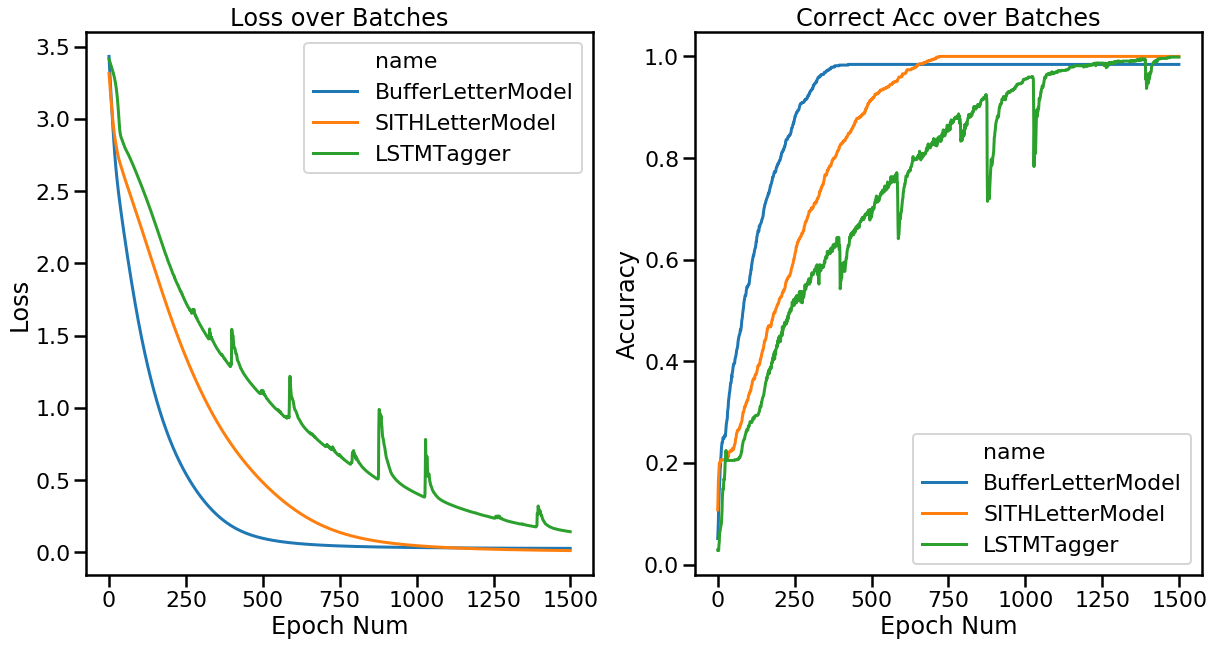

In [101]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1,2,1)
sn.lineplot(data=results, x='epoch', y='val', hue="name",
            ax=ax)
ax.set_xlabel("Epoch Num")
ax.set_ylabel("Loss")
ax.set_title("Loss over Batches")
ax = fig.add_subplot(1,2,2)
sn.lineplot(data=results, x='epoch', y='acc', hue="name",
            ax=ax)
ax.set_xlabel("Epoch Num")
ax.set_ylabel("Accuracy")
ax.set_title("Correct Acc over Batches")

# Please note that the line that is in the left graph highly fluctuates
# based on the batch within an epoch, so it looks like a filled in area but 
# is actually just a highly fluctuating line. 

# it should also be noted that a buffer of size 10 will never reach 100% 
# accuracy with this model. 
plt.savefig("results_eval", bbox_inches="tight")

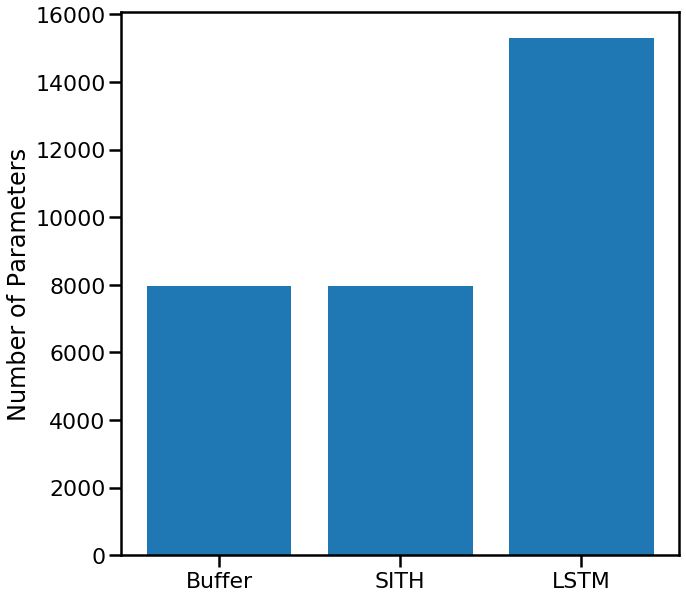

In [156]:
fig = plt.figure(figsize=(10,10))
plt.bar(["Buffer", "SITH", "LSTM"],
        [sum(p.numel() for p in buff_model.parameters()),
         sum(p.numel() for p in sith_model.parameters()),
         sum(p.numel() for p in lstm_model.parameters())])
plt.ylabel("Number of Parameters")
plt.savefig("weights", bbox_inches="tight")

## Buffer Letter Embeddings

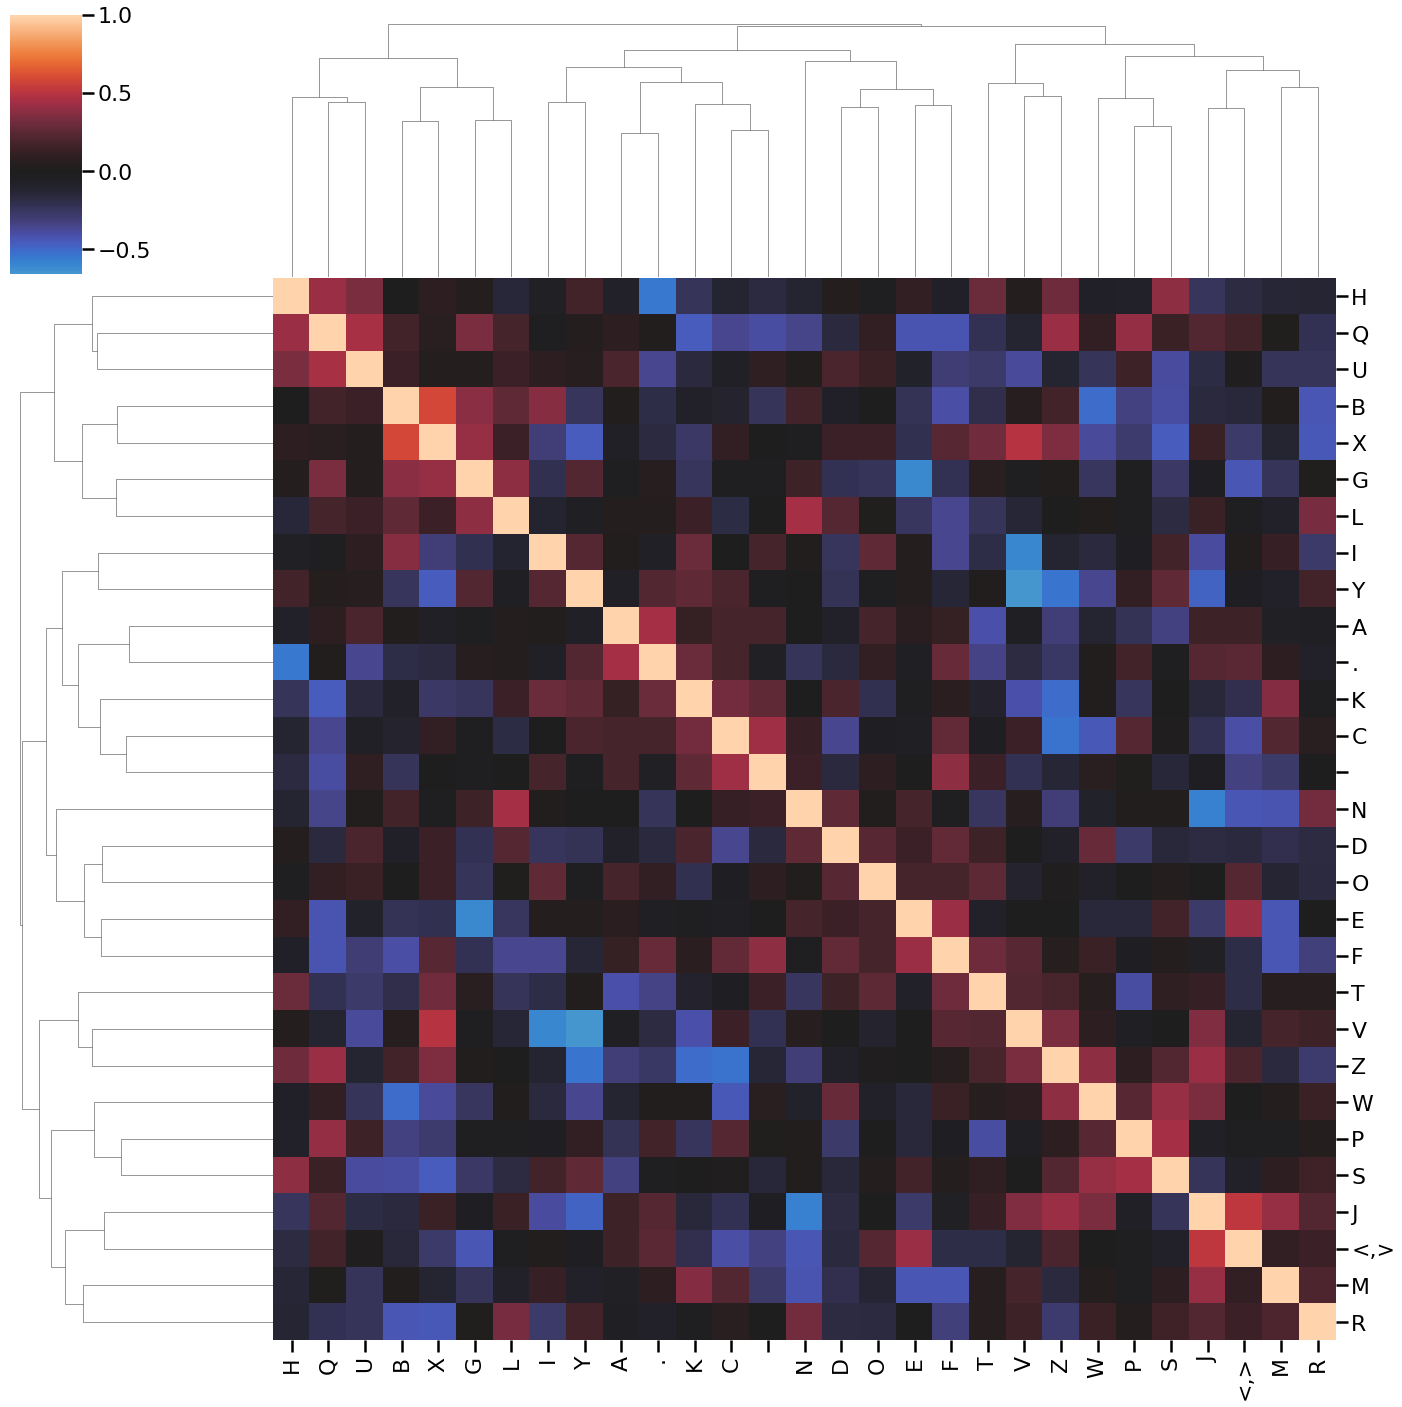

In [148]:
df = pd.DataFrame(buff_model.letter_embeddings.weight.detach().cpu().numpy().T)
df.columns = list(let_to_id.keys())
sn.clustermap(figsize=(20,20), data=df.corr(), center=0)

## SITH Letter Embeddings

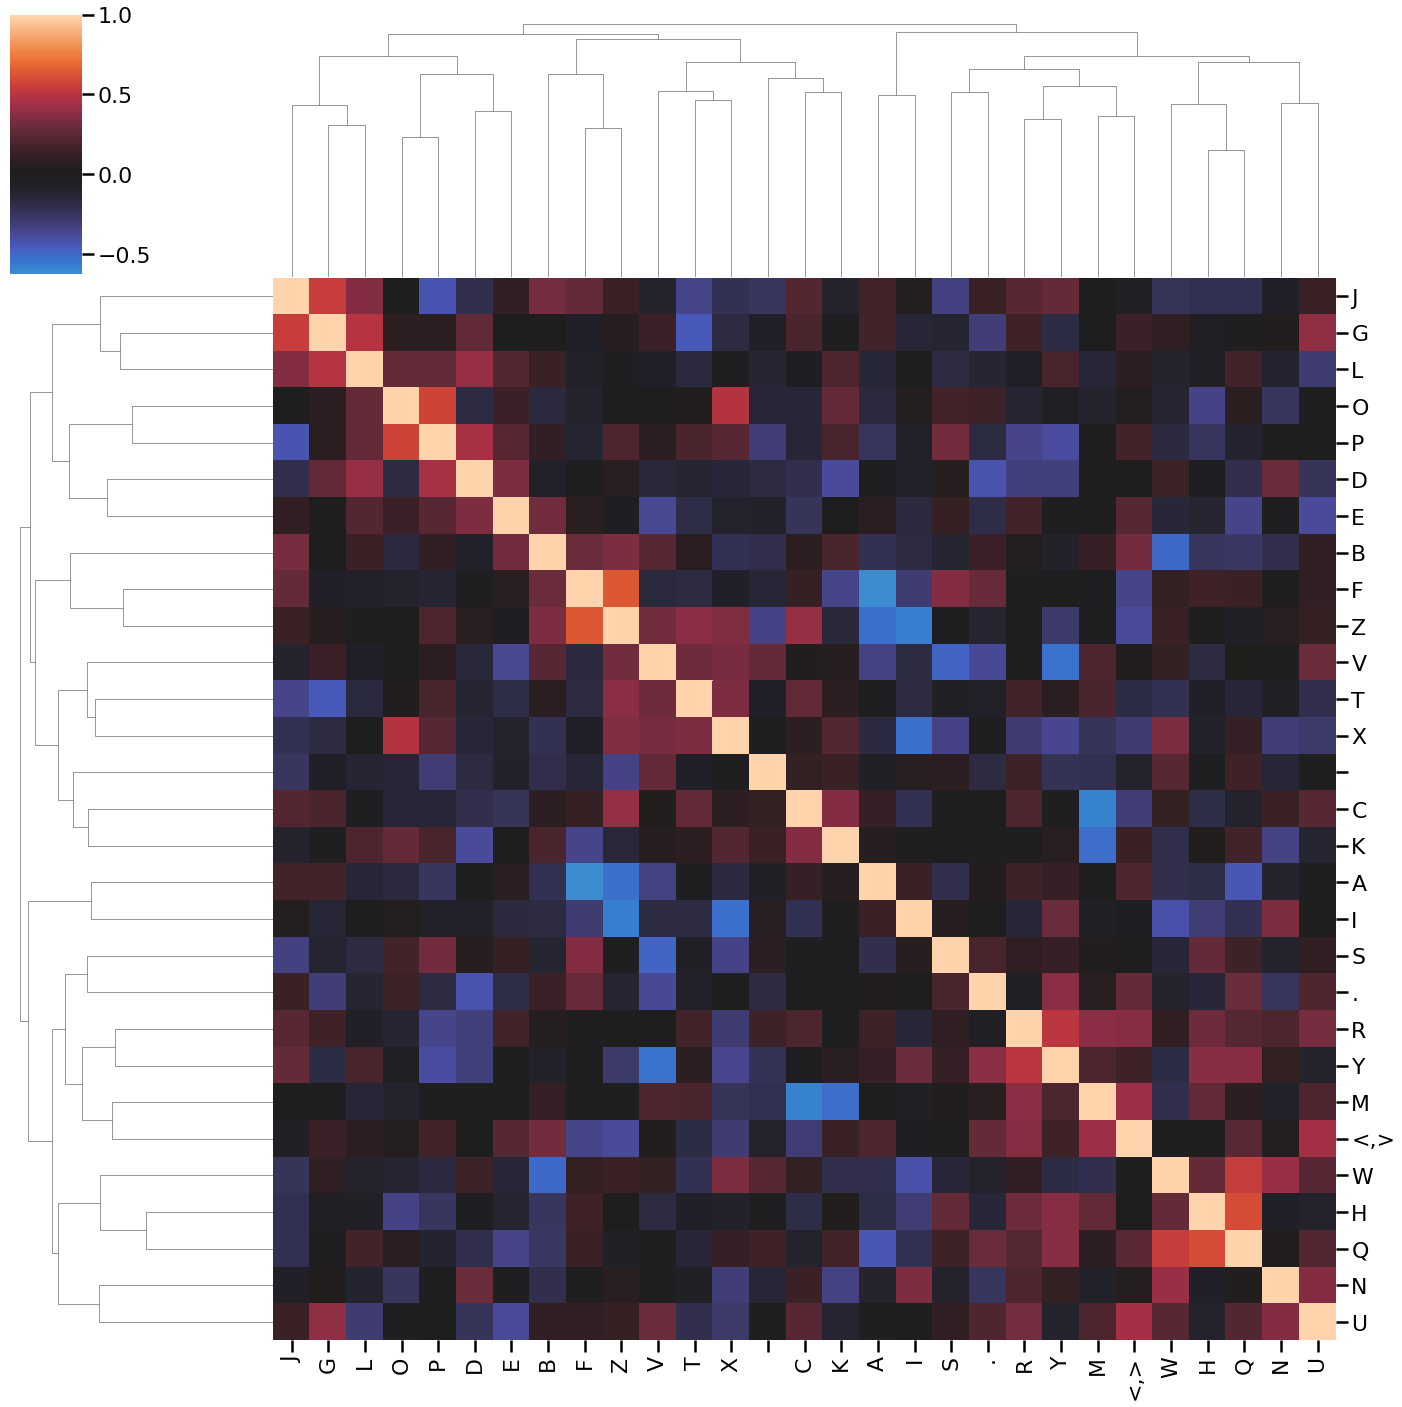

In [155]:
df = pd.DataFrame(sith_model.word_embeddings.weight.detach().cpu().numpy().T)
df.columns = list(let_to_id.keys())
sn.clustermap(figsize=(20,20), data=df.corr(), center=0)


## LSTM Letter Embeddings

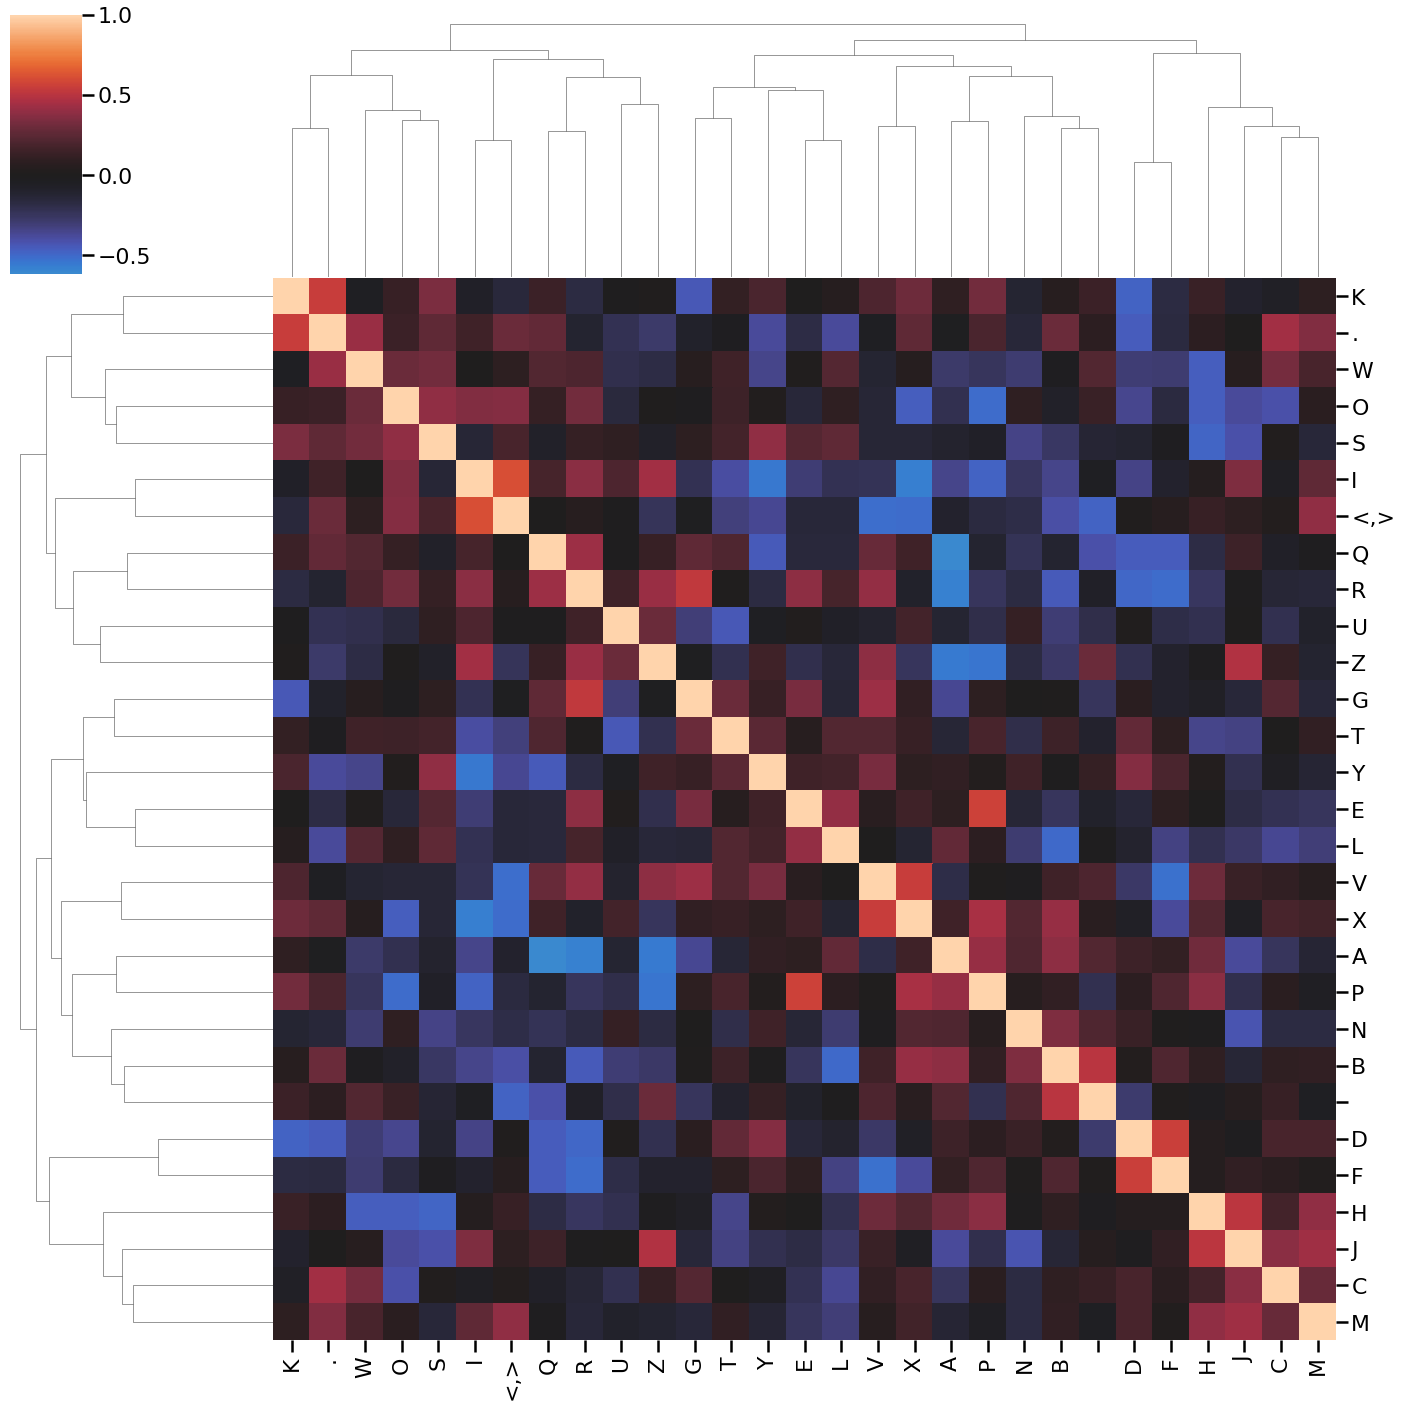

In [151]:
df = pd.DataFrame(lstm_model.word_embeddings.weight.detach().cpu().numpy().T)
df.columns = list(let_to_id.keys())
sn.clustermap(figsize=(20,20), data=df.corr(), center=0)